# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download necessary NLTK data
import nltk
from jupyter_core.version import pattern

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data from csv and labeling the data
* csv file contains two columns: review and sentiment so we dont need to label the data

In [2]:
# Define the path to the manually downloaded dataset
data_path = "data/data.csv"  # Update the file name if it's different

# Check if the file exists before attempting to load
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file not found at {data_path}. Ensure the file is in the correct location.")

# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()


Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Perform Exploratory Data Analysis (EDA)


Class distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Text length stats:
count    5842.000000
mean      117.022253
std        56.420425
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: text_length, dtype: float64


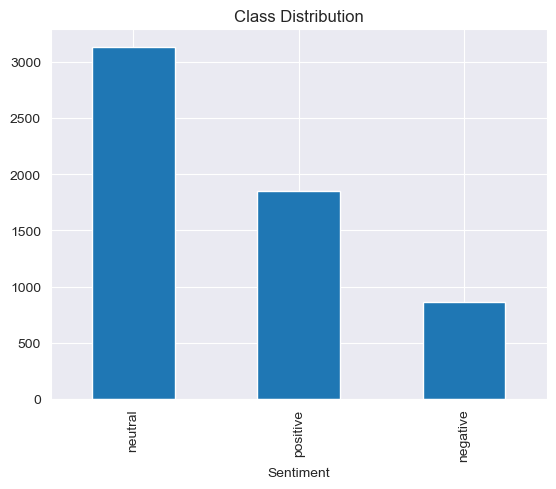

In [3]:
# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['Sentence'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)

## Data review and cleaning
so taking a look to our data we can see there are a lot of words that are domain specific and not useful for our analysis so we should remove them <br>
There is also a noticeable class imbalance:
    * Positive reviews dominate, which could make a machine learning model biased toward predicting positive sentiments.
    * Techniques like oversampling (e.g., SMOTE), undersampling, or class-weight adjustments in algorithms can address this issue.
   *  Neutral reviews are the least represented class, which might challenge the model to differentiate between neutral and other sentiments.
<br>
So we begin with data cleaning and preprocessing to remove irrelevant information and standardize the text format.

In [4]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import html
import string

# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_and_stem(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace stock tickers with 'STOCK'
    text = re.sub(r'\$[A-Za-z]+', 'STOCK', text)

    # Handle cases with currencies like USD, EUR, GBP, etc.
    text = re.sub(r'(\b(?:USD|EUR|GBP|INR|JPY|CAD|AUD|CHF|CNY|ZAR|SEK|NOK|¥|€|₹|£))\s?(\d+(\,?\d{3})*(\.\d{1,2})?)', r'\1\2', text)

    # Remove space between digits and decimal points
    text = re.sub(r'(\d)\s?\.(\d)', r'\1.\2', text)  # For cases like 1 .6 -> 1.6

    # Remove space before or after a comma in large numbers like EUR1 ,000
    text = re.sub(r'(\d)\s?,(\d)', r'\1,\2', text)  # For cases like EUR1 ,000 -> EUR1,000

    # Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
    text = re.sub(r'(\d)\s?(billion|million|bn|mn|mln)', r'\1\2', text,flags=re.IGNORECASE)

    pattern = r"(?:(?:[\$\€\¥\£])\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)?)"
    text = re.sub(pattern, r"value ", text)  # Add a space after "money_value"

    pattern2 = r"(?:USD|EUR|GBP|JPY|AUD|CAD)\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)"
    text = re.sub(pattern2, r"value ", text)  # Add a space after "money_value"

    # Replace percentages
    text = re.sub(r'\d+(\.\d+)?\s?%|(\d+(\.\d+)?\s?percent)', 'percentage', text, flags=re.IGNORECASE)
    # Replace months, dates, years, and hours
    text = re.sub(r'\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\b', 'month', text)
    text = re.sub(r'\b\d{4}\b', 'year', text)
    text = re.sub(r'\b\d{1,2}(st|nd|rd|th)\b', 'date', text)
    text = re.sub(r'\b\d{1,2}[:]\d{2}\b', 'hour', text)

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Tokenize and clean up text
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Use custom stopwords
    custom_stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in custom_stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into text
    return ' '.join(stemmed_tokens)

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_and_stem)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,geosolut technolog leverag benefon gp solut pr...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,stock low valu valu k real possibl
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,last quarter year componenta net sale doubl va...
3,According to the Finnish-Russian Chamber of Co...,neutral,128,accord finnishrussian chamber commerc major co...
4,The Swedish buyout firm has sold its remaining...,neutral,135,swedish buyout firm sold remain percentag stak...
...,...,...,...,...
95,M-Real said there are ` no grounds ' for the r...,neutral,117,mreal said ground rumor circul market month
96,Lember said the matter was topical also in Est...,neutral,173,lember said matter topic also estonia bill dra...
97,- Moody 's said it gave P A1 long-term senior ...,neutral,193,moodi said gave p a1 longterm senior unsecur p...
98,$TSLA recall,negative,12,stock recal


# Feature excraction with tf idf
now we will extract features with tf idf to get the most important words in the text

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Vectorize the cleaned text
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['cleaned_text'])  # Feature matrix




# Splitting the data into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split

# Assuming your 'sentiment' column contains labels like 'positive', 'negative', 'neutral'
y = df['Sentiment']  # Labels

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert sparse matrix to dense for SMOTE compatibility
X_train_dense = X_train.toarray()

# Apply SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_dense, y_train)


# Training with logistic regression using cross validation


Cross-Validated Metrics (Resampled Data):
Accuracy: 0.8086
Precision: 0.8105
Recall: 0.8086
F1 Score: 0.8083


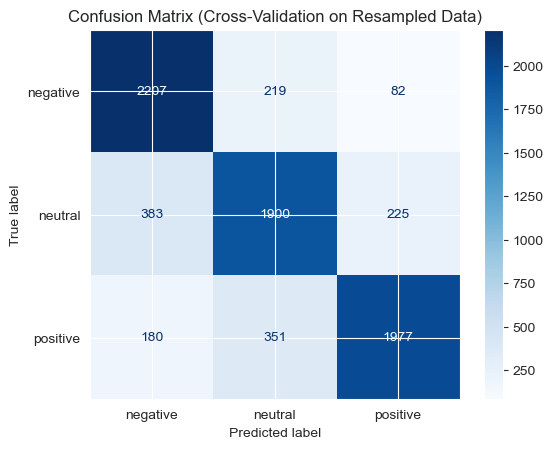


Metrics on Original Test Set:
Accuracy: 0.7109
Precision: 0.7243
Recall: 0.7109
F1 Score: 0.7161


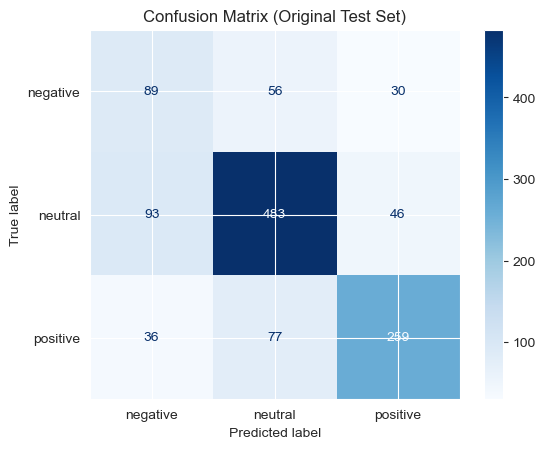

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Convert resampled X to sparse format
X_resampled = csr_matrix(X_resampled)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr', class_weight='balanced')

# Cross-validation setup: use StratifiedKFold to maintain class balance in splits
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Cross-validated predictions using the resampled data
y_pred_cv = cross_val_predict(log_reg_model, X_resampled, y_resampled, cv=cv)

# Evaluate metrics using cross-validated predictions
accuracy = accuracy_score(y_resampled, y_pred_cv)
precision = precision_score(y_resampled, y_pred_cv, average='weighted')
recall = recall_score(y_resampled, y_pred_cv, average='weighted')
f1 = f1_score(y_resampled, y_pred_cv, average='weighted')

# Display cross-validation metrics
print(f"Cross-Validated Metrics (Resampled Data):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute and display the confusion matrix for cross-validation predictions
cm = confusion_matrix(y_resampled, y_pred_cv, labels=np.unique(y_resampled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_resampled))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-Validation on Resampled Data)')
plt.show()

# Train the model on the full resampled training set
log_reg_model.fit(X_resampled, y_resampled)

# Predict the sentiment classes on the original test set
y_pred_test = log_reg_model.predict(X_test)

# Evaluate metrics for predictions on the original test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Display metrics for predictions on the test set
print("\nMetrics on Original Test Set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Compute and display the confusion matrix for the test set predictions
cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y_test))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_test))
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Original Test Set)')
plt.show()


# Training with SVM using cross validation


Cross-Validated Metrics (Resampled Data):
Accuracy: 0.8417
Precision: 0.8491
Recall: 0.8417
F1 Score: 0.8432


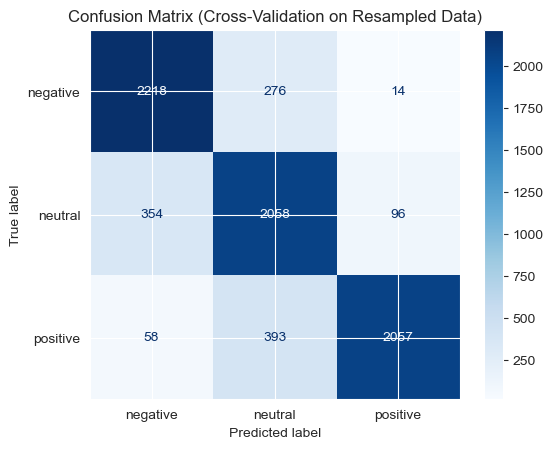


Test Set Metrics:
Accuracy: 0.7109
Precision: 0.7243
Recall: 0.7109
F1 Score: 0.7161


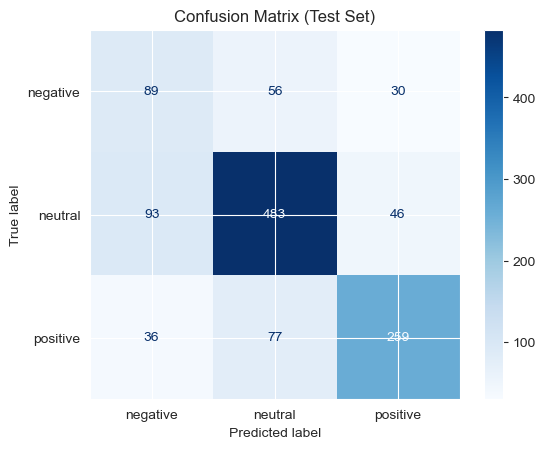

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt


# # Initialize the Support Vector Classifier (SVM) model
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced')

# Cross-validation setup: use StratifiedKFold to maintain class balance in splits
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Cross-validated predictions using the resampled data
y_pred_cv = cross_val_predict(svm_model, X_resampled, y_resampled, cv=cv)

# Evaluate metrics using cross-validated predictions
accuracy = accuracy_score(y_resampled, y_pred_cv)
precision = precision_score(y_resampled, y_pred_cv, average='weighted')
recall = recall_score(y_resampled, y_pred_cv, average='weighted')
f1 = f1_score(y_resampled, y_pred_cv, average='weighted')

# Display cross-validation metrics
print("Cross-Validated Metrics (Resampled Data):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute and display the confusion matrix for cross-validation predictions
cm = confusion_matrix(y_resampled, y_pred_cv, labels=np.unique(y_resampled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_resampled))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-Validation on Resampled Data)')
plt.show()

# Train the SVM model on the full resampled training set
svm_model.fit(X_resampled, y_resampled)

# Predict the sentiment classes on the test set
y_pred_test = log_reg_model.predict(X_test)

# Evaluate metrics for the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Display test set metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Compute and display the confusion matrix for test set predictions
cm_test = confusion_matrix(y_test, y_pred_test, labels=np.unique(y_test))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_test))
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()


# LR model SPLIT OVER


F1 Score (CV): 0.816931594844526

Classification Report (CV):
              precision    recall  f1-score   support

    negative       0.79      0.90      0.84      2508
     neutral       0.80      0.73      0.76      2508
    positive       0.87      0.82      0.84      2508

    accuracy                           0.82      7524
   macro avg       0.82      0.82      0.82      7524
weighted avg       0.82      0.82      0.82      7524



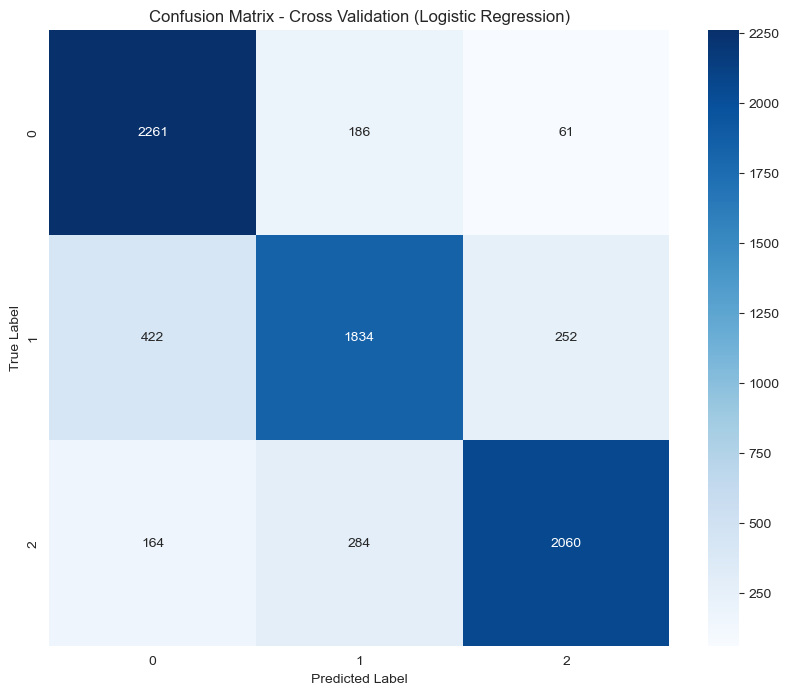


Performance on Original Test Set:
F1 Score (Test): 0.712017402232927

Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.39      0.47      0.43       175
     neutral       0.78      0.77      0.77       622
    positive       0.77      0.72      0.74       372

    accuracy                           0.71      1169
   macro avg       0.65      0.65      0.65      1169
weighted avg       0.72      0.71      0.71      1169



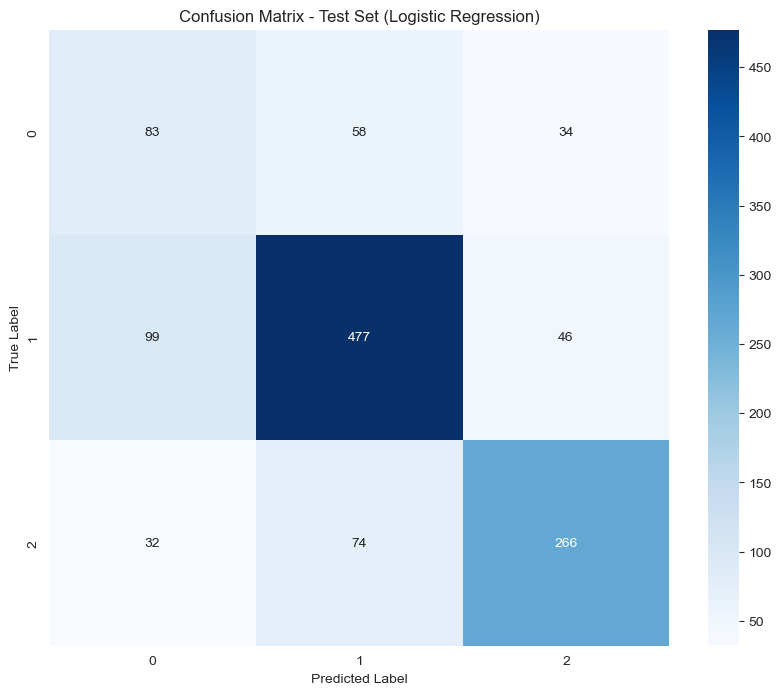

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with 'cleaned_text' for text and 'Sentiment' for labels

# Split the dataset first to keep the test set untouched by oversampling
X = df['cleaned_text']  # Text data
y = df['Sentiment']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to oversample minority classes in text data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert numpy arrays back to pandas Series for easier handling
X_resampled = pd.Series([x[0] for x in X_resampled.tolist()], index=pd.RangeIndex(len(X_resampled)))
y_resampled = pd.Series(y_resampled, index=pd.RangeIndex(len(y_resampled)))

# Feature extraction on the resampled data
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_resampled = vectorizer.fit_transform(X_resampled)

# Feature extraction on the test data (using the vocabulary from the resampled training data)
X_test = vectorizer.transform(X_test)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Cross-validation setup with 15 folds
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Perform cross-validation on the resampled and vectorized training data
y_pred_cv = cross_val_predict(log_reg_model, X_train_resampled, y_resampled, cv=cv)

# Evaluate the model using cross-validation results
print(f"F1 Score (CV): {f1_score(y_resampled, y_pred_cv, average='weighted')}")
print("\nClassification Report (CV):")
print(classification_report(y_resampled, y_pred_cv))

# Confusion Matrix for Cross-Validation
cm_cv = confusion_matrix(y_resampled, y_pred_cv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Cross Validation (Logistic Regression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Train the model on all resampled training data and predict on the test set
log_reg_model.fit(X_train_resampled, y_resampled)
y_pred_test = log_reg_model.predict(X_test)

# Evaluate on the original test set
print("\nPerformance on Original Test Set:")
print(f"F1 Score (Test): {f1_score(y_test, y_pred_test, average='weighted')}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (Logistic Regression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# SVM model Split OVERSAMPLE FEATURE EXTRACTION

F1 Score (CV): 0.8691192936892798

Classification Report (CV):
              precision    recall  f1-score   support

    negative       0.83      0.95      0.89      2508
     neutral       0.85      0.79      0.82      2508
    positive       0.94      0.87      0.90      2508

    accuracy                           0.87      7524
   macro avg       0.87      0.87      0.87      7524
weighted avg       0.87      0.87      0.87      7524



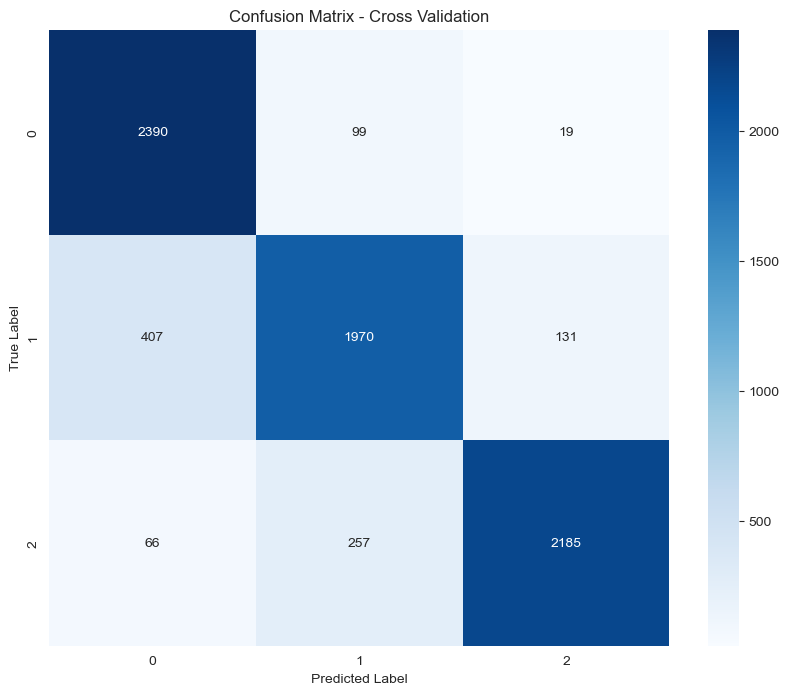


Performance on Original Test Set:
F1 Score (Test): 0.6976521770929676

Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.36      0.37      0.36       175
     neutral       0.74      0.81      0.77       622
    positive       0.81      0.67      0.73       372

    accuracy                           0.70      1169
   macro avg       0.63      0.62      0.62      1169
weighted avg       0.70      0.70      0.70      1169



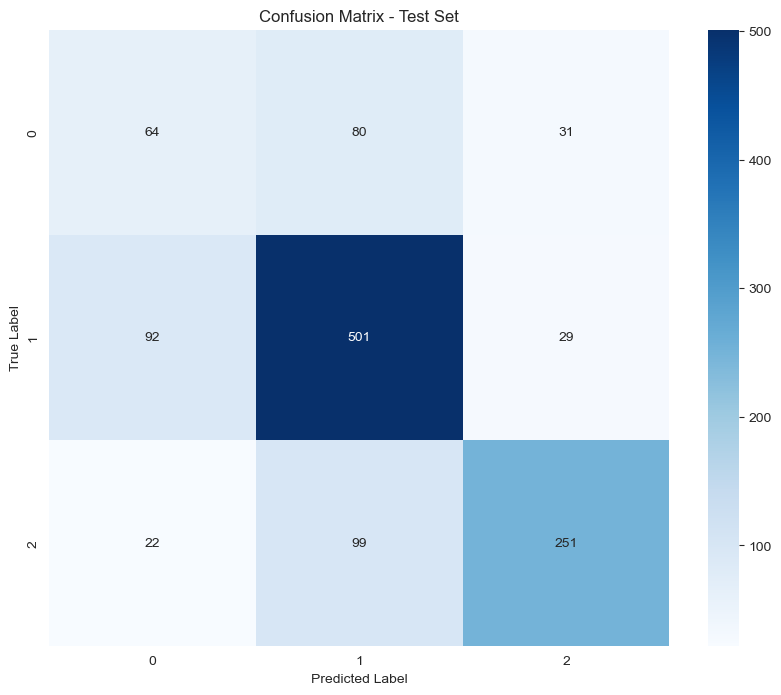

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Split the dataset first to keep the test set untouched by oversampling
X = df['cleaned_text']  # Text data
y = df['Sentiment']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to oversample minority classes in text data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert numpy arrays back to pandas Series for easier handling
X_resampled = pd.Series([x[0] for x in X_resampled.tolist()], index=pd.RangeIndex(len(X_resampled)))
y_resampled = pd.Series(y_resampled, index=pd.RangeIndex(len(y_resampled)))

# Feature extraction on the resampled data
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_resampled = vectorizer.fit_transform(X_resampled)

# Feature extraction on the test data (using the vocabulary from the resampled training data)
X_test = vectorizer.transform(X_test)

# Initialize the SVM model with RBF kernel
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Cross-validation setup with 15 folds
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Perform cross-validation on the resampled and vectorized training data
y_pred_cv = cross_val_predict(svm_model, X_train_resampled, y_resampled, cv=cv)

# Evaluate the model using cross-validation results
print(f"F1 Score (CV): {f1_score(y_resampled, y_pred_cv, average='weighted')}")
print("\nClassification Report (CV):")
print(classification_report(y_resampled, y_pred_cv))

# Confusion Matrix for Cross-Validation
cm_cv = confusion_matrix(y_resampled, y_pred_cv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Cross Validation')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Train the model on all resampled training data and predict on the original test set
svm_model.fit(X_train_resampled, y_resampled)
y_pred_test = svm_model.predict(X_test)

# Evaluate on the original test set
print("\nPerformance on Original Test Set:")
print(f"F1 Score (Test): {f1_score(y_test, y_pred_test, average='weighted')}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()